# French House prices

In [136]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(20,7)})
import matplotlib.pyplot as plt
import numpy as np
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import scipy.stats as stats

from jupyterthemes import jtplot
jtplot.style()

In [137]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

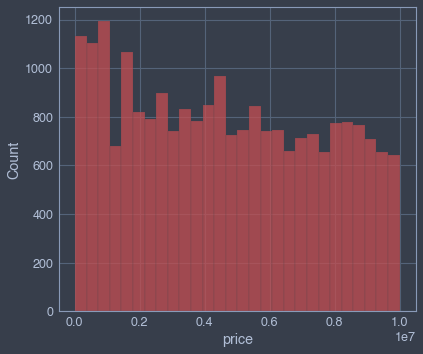

In [138]:
# price is our target
sns.histplot(train_df['price'], color='r')
plt.show()

In [139]:
print(np.min(train_df['price']))
print(np.max(train_df['price']))

10313.5
10004278.3


The distribution is incredibly flat but also really broad, so let's try and and manipulate the data. This isn't a very realistic model! Let's just check quality of data for nans

In [140]:
train_df.isnull().sum()

id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

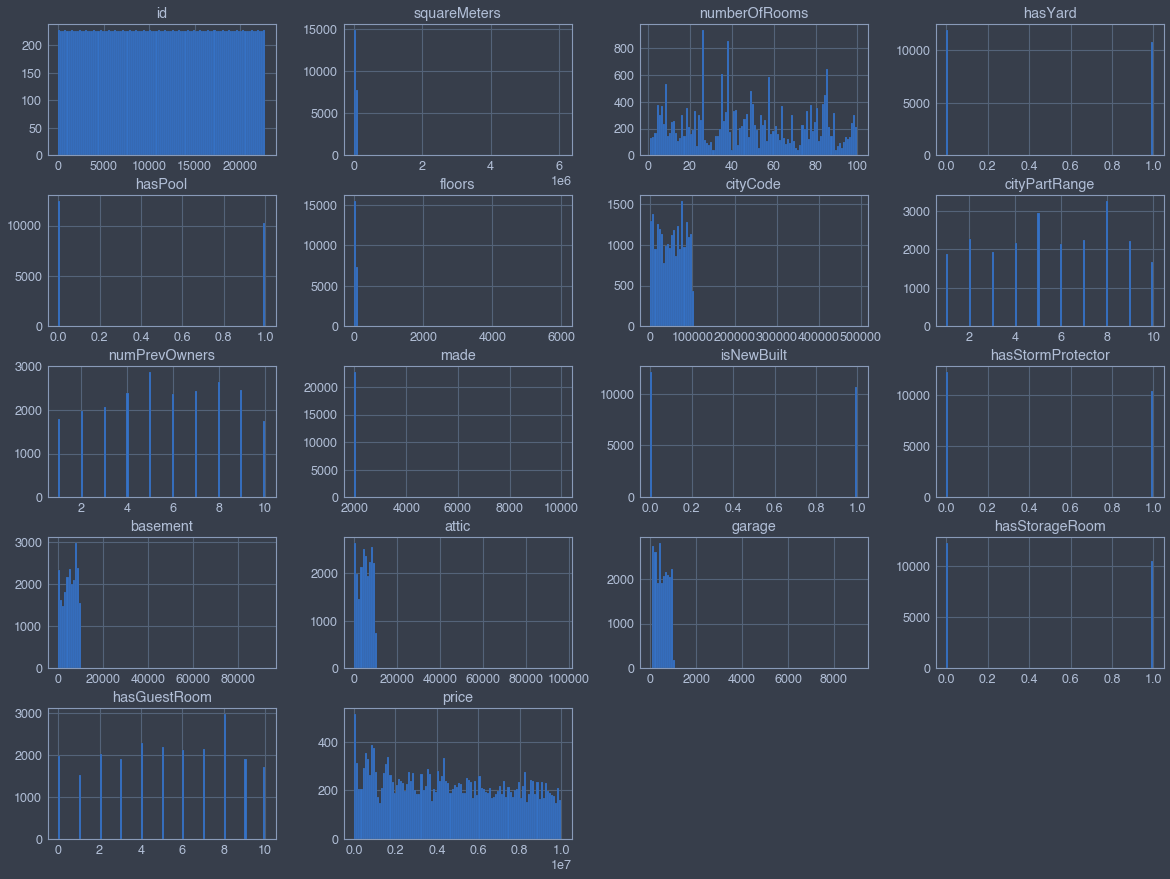

In [141]:
# Let's look at the data and lookf or outliers
train_df.hist(bins=100, figsize=(20, 15))
plt.show()

In [163]:
# Drop outliers  
train_df.drop(train_df[train_df['squareMeters'] > 200000].index, inplace=True)
train_df.drop(train_df[train_df['floors'] > 100].index, inplace=True)
train_df.drop(train_df[train_df['attic'] > 20000].index, inplace=True)
train_df.drop(train_df[train_df['garage'] > 1000].index, inplace=True)
train_df.drop(train_df[train_df['cityCode'] > 20000].index, inplace=True)
train_df.drop(train_df[train_df['basement'] > 20000].index, inplace=True)

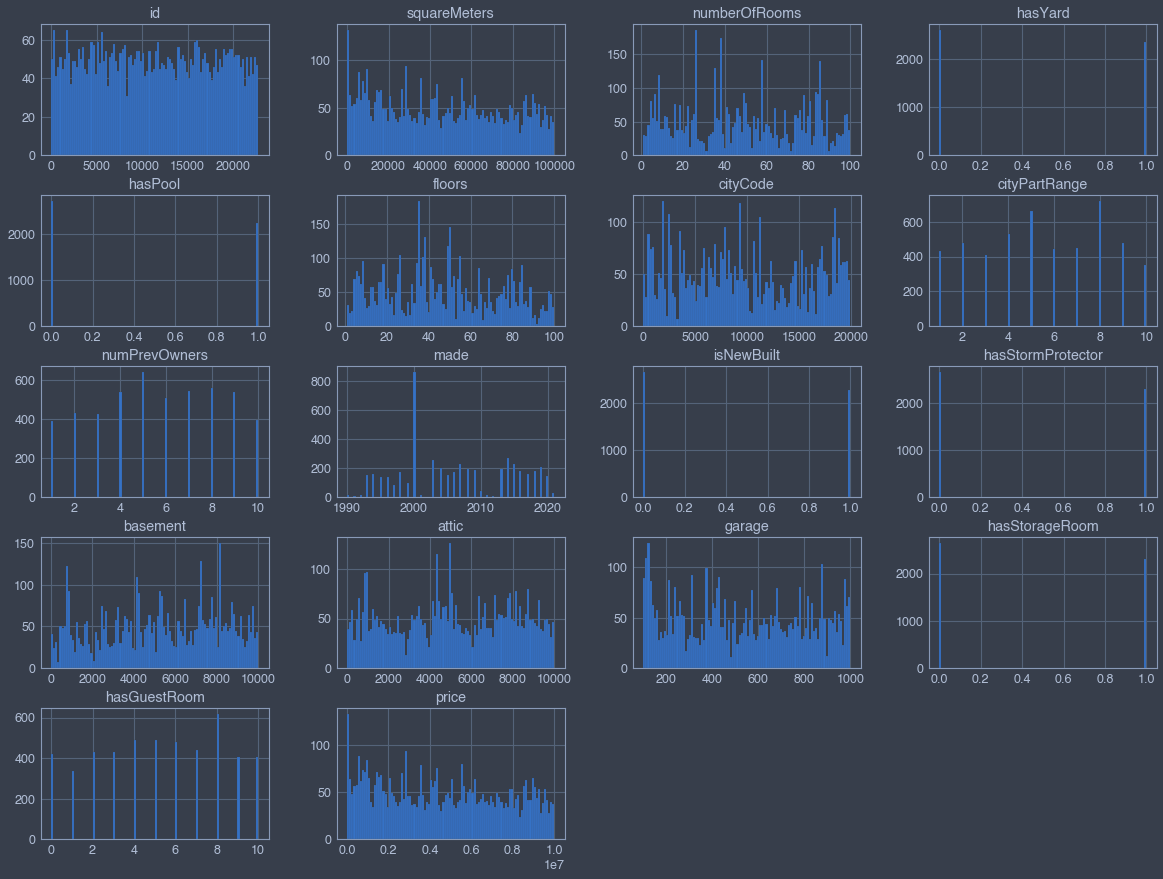

In [164]:
# Let's look at the data and lookf or outliers
train_df.hist(bins=100, figsize=(20, 15))
plt.show()

In [165]:
train_df_copy = train_df.copy()
train_df_copy['price'] = train_df['price']

No nans which is great! Let's look at the correlations between data

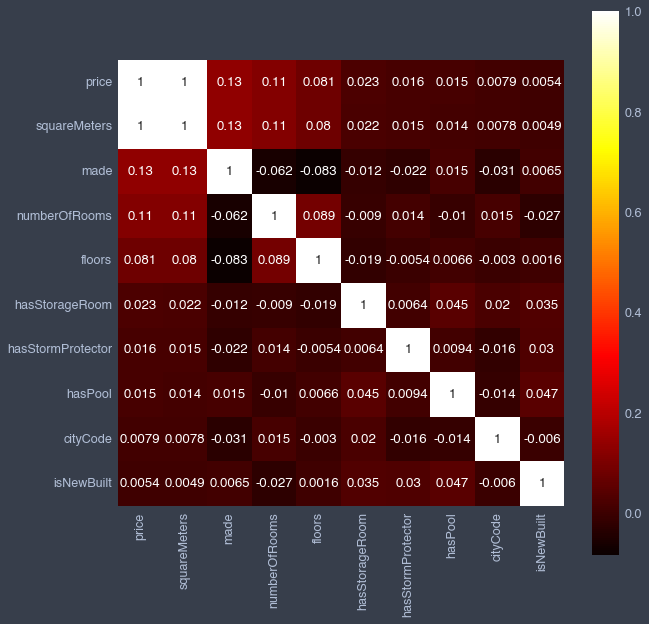

In [166]:
correlation_matrix = train_df_copy.corr()

# Get columns of top 10 most correlated parameters
cols = correlation_matrix.nlargest(10, ['price'])['price'].index

# Compute pearson correlation coefficient
cm = np.corrcoef(train_df_copy[cols].values.T)

# Plot heat map
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap='hot', cbar=True, square=True, annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Basically, it looks like square meeters is the most strongly correlated result. Let's train this model using XGBoost. We want to use grid search to find the best parameters

In [170]:
# Various hyper-parameters to tune
reg = XGBRegressor(n_estimators=1500, 
                   max_depth=5, 
                   learning_rate = 0.02, 
                   min_child_weight= 4,
                   subsample = 0.7,
                   objective='reg:squarederror')
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# reg_grid = GridSearchCV(reg,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

In [171]:
train_y = train_df_copy['price']
train_X = train_df_copy.drop(columns=['price'])

# We also want to split data for evaluation
train_X_s, test_X, train_y_s, test_y = train_test_split(train_X, train_y, test_size=0.3)

# Fit model
reg.fit(train_X, train_y, eval_set = [(train_X_s, train_y_s), (test_X, test_y)], verbose=100)

print(reg_grid.best_score_)
print(reg_grid.best_params_)

[0]	validation_0-rmse:5376481.17665	validation_1-rmse:5305029.55136
[100]	validation_0-rmse:728330.93859	validation_1-rmse:720194.52900
[200]	validation_0-rmse:127605.81684	validation_1-rmse:141479.64811
[300]	validation_0-rmse:72413.80334	validation_1-rmse:86696.85204
[400]	validation_0-rmse:57290.94747	validation_1-rmse:68966.03293
[500]	validation_0-rmse:43051.18350	validation_1-rmse:53503.44154
[600]	validation_0-rmse:35427.91553	validation_1-rmse:43272.50780
[700]	validation_0-rmse:30479.60986	validation_1-rmse:36785.33198
[800]	validation_0-rmse:27117.10699	validation_1-rmse:32000.90210
[900]	validation_0-rmse:24300.81104	validation_1-rmse:27969.28841
[1000]	validation_0-rmse:22221.11965	validation_1-rmse:25088.80567
[1100]	validation_0-rmse:20325.27277	validation_1-rmse:22709.38782
[1200]	validation_0-rmse:18692.84418	validation_1-rmse:20930.84903
[1300]	validation_0-rmse:17205.79556	validation_1-rmse:19312.37537
[1400]	validation_0-rmse:16104.21374	validation_1-rmse:17659.95770

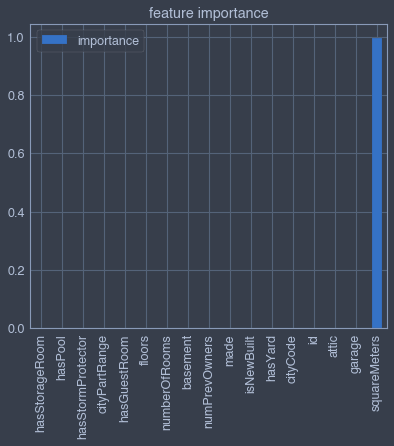

In [173]:
# Let's look at the feature importances
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fi.sort_values('importance').plot(kind='bar', title='feature importance')
plt.show()

Unsurprisingly, squaremeters absolutely dominates. Let's retrain but on the whole dataset, then make predictions

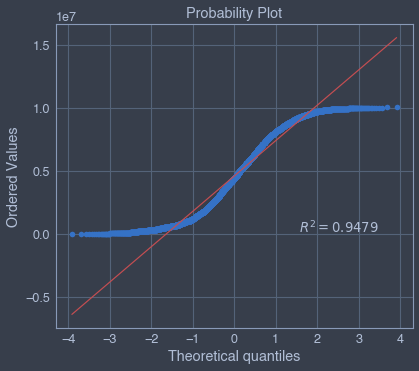

In [174]:
# Now make predictions 
test_y = reg.predict(test_df)

# Let's take a look this data
stats.probplot(test_y, plot=plt, rvalue=True)

plt.show()

In [175]:
# Create submission
# Create data submission 
sub_df = test_df.copy()
sub_df['price'] = test_y
submission = sub_df[['id', 'price']]
submission.to_csv('./submission_xgboost.csv', index=None)